In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

prod = "[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10][CH2:9][NH:8][CH2:13][CH2:12]1"
reac = "c1ccc(C[N:8]2[CH2:9][CH2:10][N:11]([S:14](=[O:15])(=[O:16])[CH3:17])[CH2:12][CH2:13]2)cc1"

template = "[C]-[NH;D2;+0]-[C]>>[C]-[N;H0;D3;+0](-[C])-C-c1:c:c:c:c:c:1"

s1=[Chem.MolFromSmiles(x) for x in ('NC','NCC')]
s2=[Chem.MolFromSmiles(x) for x in ('OC=O','OC(=O)C')]
rxn = AllChem.ReactionFromSmarts('[O:2]=[C:1][OH].[N:3]>>[O:2]=[C:1][N:3]')
r = AllChem.EnumerateLibraryFromReaction(rxn,[s2,s1])
[Chem.MolToSmiles(x[0]) for x in list(r)]

['CNC=O', 'CCNC=O', 'CNC(C)=O', 'CCNC(C)=O']

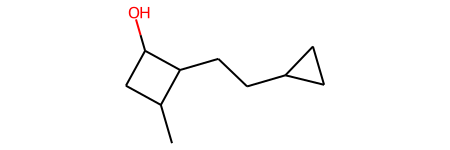

In [4]:
m = Chem.MolFromSmiles('CC1CC(O)C1CCC1CC1')
bs = [4]
nm = Chem.FragmentOnBonds(m, bs, addDummies=False)
bs = [3]
nm2 = Chem.FragmentOnBonds(m, bs, addDummies=False)
smi = Chem.MolToSmiles(nm)
m

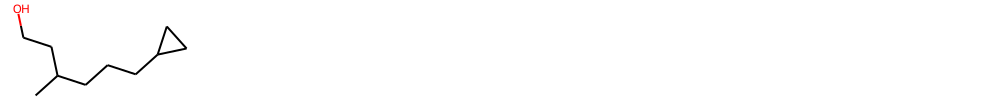

In [5]:
from rdkit.Chem import AllChem, Draw
mol_list = Chem.GetMolFrags(nm, asMols=True)
imgs = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(200,100))
imgs

N1(CCOc2c(OC3CCCC3)cc3c(c2)ncnc3Nc2ccc(F)c(Cl)c2)CCN(C[C@@H]2OC(=O)CC2)CC1


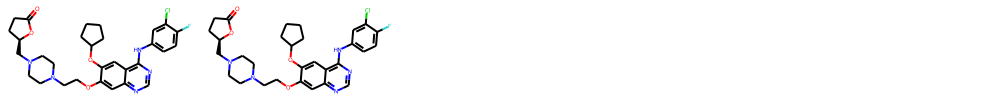

In [20]:
import numpy as np

smi = "C([C@H]1CCC(=O)O1)N1CCN(CCOc2cc3ncnc(Nc4ccc(F)c(Cl)c4)c3cc2OC2CCCC2)CC1"
m = Chem.MolFromSmiles(smi)
ans = list(range(m.GetNumAtoms()))
np.random.shuffle(ans)
nm = Chem.RenumberAtoms(m, ans)
smi_random = Chem.MolToSmiles(nm, canonical=False)
mol_list = [nm, m]
imgs = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(200,100))
print(smi_random)
imgs

In [27]:
import re
def smi_tokenizer(smi):
    """Tokenize a SMILES sequence or reaction"""
    pattern = "(\[[^\]]+]|Bi|Br?|Ge|Te|Mo|K|Ti|Zr|Y|Na|125I|Al|Ce|Cr|Cl?|Ni?|O|S|Pd?|Fe?|I|b|c|Mn|n|o|s|<unk>|>>|Li|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    if smi != ''.join(tokens):
        print('ERROR:', smi, ''.join(tokens))
    assert smi == ''.join(tokens)
    return tokens

def mol_map_diff_smiles(smi1, smi2):
    from rdkit.Chem.rdFMCS import FindMCS

    src_chars = smi_tokenizer(smi1)
    tgt_chars = smi_tokenizer(smi2)

    src_mol = Chem.MolFromSmiles(smi1)
    tgt_mol = Chem.MolFromSmiles(smi2)

    atom_map = torch.zeros(src_mol.GetNumAtoms(), tgt_mol.GetNumAtoms())
    cross_attn = torch.zeros(len(src_chars), len(tgt_chars))
    not_atom_indices_src = list()
    atom_indices_src = list()
    pad_indices_src = list()
    not_atom_indices_tgt = list()
    atom_indices_tgt = list()
    pad_indices_tgt = list()

    tgt_mol = Chem.MolFromSmiles(smi2)
    mols = [src_mol, tgt_mol]
    result = FindMCS(mols, timeout=10)
    result_mol = Chem.MolFromSmarts(result.smartsString)

    
    src_mat = src_mol.GetSubstructMatches(result_mol)
    tgt_mat = tgt_mol.GetSubstructMatches(result_mol)

    mol_list = [src_mol, tgt_mol, result_mol]
    imgs = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(200,100))

    if len(src_mat) > 0 and len(tgt_mat) > 0:
        for i, j in zip(src_mat[0], tgt_mat[0]):
            atom_map[i, j] = 1
    
    print(atom_map)
    return imgs

import numpy as np
import torch
torch.set_printoptions(threshold=np.inf)
smi1 = "C([C@H]1CCC(=O)O1)N1CCN(CCOc2cc3ncnc(Nc4ccc(F)c(Cl)c4)c3cc2OC2CCCC2)CC1"
# smi2 = "O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1"
smi2 = "C([C@H]1CCC(=O)O1)N1CCN(CCOc2cc3ncnc(Nc4ccc(F)c(Cl)c4)c3cc2OC2CCCC2)CC1"
imgs = mol_map_diff_smiles(smi1, smi2)
# imgs

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.,